
<h1 style="border: 2px solid black; padding: 15px; border-radius: 12px;" align='center'>Cours IA et Applications</h1>    

<h2 align='center'> Deep Learning : Transfert learning </h2>

<h3 align='center'> Jordy Palafox </h3>
<h3 align='center'> Ing2 GSI/MI - 2023/2024 </h3>
      
      
<div style="display:flex"> 
    <img src="cytech.png", style="width:250px;height:50"> 
    <img src="cy.jpg", style="width:300px;height:100px"> 
</div> 

On se propose de suivre le "tuto" présenté ici : https://datacorner.fr/vgg-transfer-learning/

On se propose de créer un classifieur d'images de fruits !

Pour cela, on va utiliser la partie convolution du modèle pré-entraîné VGG16 et entraîner un classifieur au dessus !

# Chargeons les libraries 

In [1]:
import numpy as np
import pandas as pd
from glob import glob
 
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
 
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

# Et regardons une petite image 

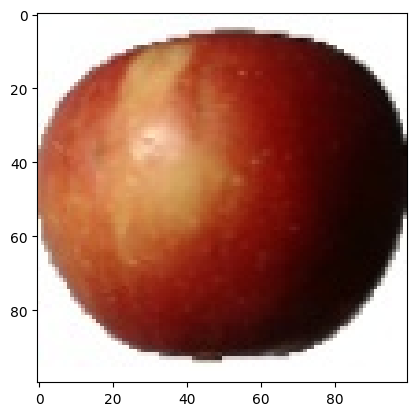

In [2]:
image = imread("archive/fruits-360_dataset/fruits-360/Training/Apple Braeburn/0_100.jpg")
plt.imshow(image)

In [3]:
# Vérifions la forme de l'image 
image.shape

(100, 100, 3)

C'est donc bien un tenseur de dimension 3 autrement dit 3 matrices de taille 100 x 100 supperposées.

# On va en profiter pour tester la data augmentation !

In [7]:
src_path_train = "archive/fruits-360_dataset/fruits-360/Training"
src_path_test = "archive/fruits-360_dataset/fruits-360/Test"
batch_size = 8

IMSIZE = [100,100] 
 
image_gen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)
 
# create generators
train_generator = image_gen.flow_from_directory(
  src_path_train,
  target_size=IMSIZE,
  shuffle=True,
  batch_size=batch_size,
)
 
test_generator = image_gen.flow_from_directory(
  src_path_test,
  target_size=IMSIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# Passons à la défintion et paramétrisation du modèle 

+ L'utilisation de la classe VGG16 fournie par TensorFlow (ici on utilise les poids imagenet), include_top précise que l'on prend tout le modèle sauf la dernière couche.
+ Nous marquons les couches du réseau de neurones afin de ne pas écraser l'apprentissage déjà récupéré (layer.trainable = False)
+ L'ajout d'une nouvelle couche Dense à la fin (on pourrait en ajouter d'autres d'ailleurs), c'est cette couche qui va faire le choix de tel ou tel fruit.

Traduit avec www.DeepL.com/Translator (version gratuite) => et oui (et c'est du NLP derrière, au prochain chapitre)

In [8]:
# nombre de classes
NBCLASSES = 131
train_image_files = glob(src_path_train + '/*/*.jp*g')
test_image_files = glob(src_path_test + '/*/*.jp*g')
 
    
def create_model():
    """
    Ici on créé le modèle en partant de la base de VGG16,
    ses couches ne seront pas entraînables
    """
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights
    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    # ici elles sont entraînables
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model
 
mymodel = create_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

![image](vgg_2.png)

![image](vgg_1.jpg)

# On voit ici les 15 millions de paramètres, mais on n'entraîne seulement une partie !

In [9]:
epochs = 10
early_stop = EarlyStopping(monitor='loss',patience=3)
 
mymodel.fit(
  train_generator,
  epochs=epochs,
  steps_per_epoch=len(train_image_files) // batch_size,
  validation_steps=len(test_image_files) // batch_size,
  callbacks=[early_stop]
)

Epoch 1/10
8461/8461 [==============================] - 109s 13ms/step - loss: 0.0075 - accuracy: 0.8905
Epoch 2/10
8461/8461 [==============================] - 111s 13ms/step - loss: 0.0017 - accuracy: 0.9869
Epoch 3/10
8461/8461 [==============================] - 109s 13ms/step - loss: 0.0011 - accuracy: 0.9936
Epoch 4/10
8461/8461 [==============================] - 109s 13ms/step - loss: 7.9768e-04 - accuracy: 0.9961
Epoch 5/10
8461/8461 [==============================] - 116s 14ms/step - loss: 6.4813e-04 - accuracy: 0.9969
Epoch 6/10
8461/8461 [==============================] - 114s 14ms/step - loss: 5.5580e-04 - accuracy: 0.9975
Epoch 7/10
8461/8461 [==============================] - 115s 14ms/step - loss: 4.7639e-04 - accuracy: 0.9982
Epoch 8/10
8461/8461 [==============================] - 110s 13ms/step - loss: 4.3643e-04 - accuracy: 0.9984
Epoch 9/10
8461/8461 [==============================] - 112s 13ms/step - loss: 3.7744e-04 - accuracy: 0.9985
Epoch 10/10
8461/8461 [========

Le earlystopping ici est sans effet car on continue de progresser au bout de 10 époques !

# Evaluation finale 

In [10]:
score = mymodel.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2836/2836 [==============================] - 40s 14ms/step - loss: 0.0047 - accuracy: 0.9622
Test loss: 0.004696352872997522
Test accuracy: 0.9621826410293579


Le modèle fait moins bien sur les données de test, c'est souvent le cas. A vous de juger si la généralisation à de nouvelles données est suffisament bonne ou s'il faut améliorer l'approche !